# Local Outlier Factor

```python
from sklearn.neighbors import LocalOutlierFactor
```

Local Outlier Factor (LOF) adalah salah satu metode dalam data mining untuk mendeteksi outlier (pencilan) berdasarkan kepadatan lokal (local density) data. Berbeda dengan metode global outlier detection (seperti Z-score atau IQR), LOF mempertimbangkan distribusi data di sekitar suatu titik (neighborhood), sehingga cocok untuk mendeteksi outlier di daerah dengan kepadatan yang tidak seragam.

In [17]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

## Get Data from JSON

In [18]:
try:
  with open('data/tugas3/data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
except FileNotFoundError:
  print("Error: File 'data.json' tidak ditemukan!")
  exit()
except json.JSONDecodeError:
  print("Error: Format file JSON tidak valid!")
  exit()

## Data Contents

In [19]:
with open('data/tugas3/data.json', 'r', encoding='utf-8') as f:
  data = json.load(f)

# Header
print(f"{'Nama':<15} | {'BB':>5} | {'TB':>5}")
print("-" * 30)

# Isi
for item in data:
  print(f"{item['Nama']:<15} | {item['BB']:>5} | {item['TB']:>5.2f}")

Nama            |    BB |    TB
------------------------------
Achmad          |   150 |  2.71
Ridho           |    80 |  1.85
Fa'iz           |   100 |  4.60
Edho            |    85 |  1.90
Nur             |    72 |  1.70
Ratu            |    71 |  1.65
Berlian         |    70 |  1.60
Tri             |    70 |  1.95
Kurniawati      |    70 |  1.90
Mendrofa        |    70 |  1.85


## ***LOF Calculation Steps***

**Data Preprocessing**: Sebelum menghitung **Local Outlier Factor (LOF)**, kita perlu melakukan preprocessing agar data bisa digunakan dengan benar dalam perhitungan berbasis jarak:

1. **Menghapus Kolom Nama** → LOF hanya bekerja dengan data numerik.
2. **Mengecek Skala Data** → Kolom **BB (Berat Badan)** dan **TB (Tinggi Badan)** memiliki skala berbeda (BB dalam kg dan TB dalam meter). Untuk menghindari dominasi satu fitur, kita perlu **normalisasi** atau **standarisasi** datanya.
3. **Normalization or Standardization**
  - Normalize menggunakan Min-Max Scaling:

    $$
    X' = \frac{X - X_{\min}}{X_{\max} - X_{\min}}
    $$

    - di mana $ X_{\min} $ dan $ X_{\max} $ adalah nilai minimum dan maksimum dari setiap fitur.
  - Standardization menggunakan StandardScaler

    $$
    X' = \frac{X - \mu}{\sigma}
    $$

    di mana:
    - $ X' $ adalah nilai yang sudah dinormalisasi.
    - $ X $ adalah nilai asli.
    - $ \mu $ adalah **mean (rata-rata)** dari fitur.
    - $ \sigma $ adalah **standar deviasi** dari fitur.

### **Calculate StandardScaler**

```python
from sklearn.preprocessing import StandardScaler
```

1. **Mean**

$$
\mu_{\text{BB}} = \frac{150 + 80 + 100 + 85 + 72 + 71 + 70 + 70 + 70 + 70}{10} = \frac{838}{10} = 83.8
$$

$$
\mu_{\text{TB}} = \frac{2.71 + 1.85 + 4.60 + 1.90 + 1.70 + 1.65 + 1.60 + 1.95 + 1.90 + 1.85}{10} = \frac{21.71}{10} = 2.171
$$

2. **Standard Deviation**

$$
\sigma_{\text{BB}} = \sqrt{\frac{(150 - 83.8)^2 + (80 - 83.8)^2 + ... + (70 - 83.8)^2}{10}}
$$

$$
\sigma_{\text{BB}} \approx 23.81
$$

$$
\sigma_{\text{TB}} = \sqrt{\frac{(2.71 - 2.171)^2 + (1.85 - 2.171)^2 + ... + (1.85 - 2.171)^2}{10}}
$$

$$
\sigma_{\text{TB}} \approx 0.886
$$

1. **StandardScaler**

$$
X' = \frac{X - \mu}{\sigma}
$$

| Nama       | BB  | TB   | BB_scaled | TB_scaled |
|------------|-----|------|-----------|-----------|
| Achmad     | 150 | 2.71 | 2.785     | 0.680     |
| Ridho      | 80  | 1.85 | -0.160    | -0.363    |
| Fa'iz      | 100 | 4.60 | 0.680     | 2.739     |
| Edho       | 85  | 1.90 | -0.105    | -0.307    |
| Nur        | 72  | 1.70 | -0.499    | -0.531    |
| Ratu       | 71  | 1.65 | -0.541    | -0.588    |
| Berlian    | 70  | 1.60 | -0.582    | -0.645    |
| Tri        | 70  | 1.95 | -0.582    | -0.252    |
| Kurniawati | 70  | 1.90 | -0.582    | -0.307    |
| Mendrofa   | 70  | 1.85 | -0.582    | -0.363    |

**Standardization Result**
| Nama  | BB  | TB   | BB_scaled | TB_scaled |
|-------|-----|------|-----------|-----------|
| Fa'iz | 100 | 4.60 | 2.785     | 0.680     |

Sekarang, kita akan menggunakan nilai **BB_scaled** dan **TB_scaled** untuk perhitungan Euclidean.

### Euclidean Distance

Untuk **k=3**, kita harus mencari 3 tetangga terdekat dari `Fa'iz` berdasarkan jarak Euclidean.

**Rumus Euclidean Distance**

$$
d(A, B) = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}
$$

di mana:
- $ x_1, y_1 $ adalah koordinat `Fa'iz` (**2.785, 0.680**).
- $ x_2, y_2 $ adalah koordinat dari setiap titik lainnya.

**Menghitung jarak `Fa'iz` dengan semua titik lainnya**
| Nama           | BB_scaled | TB_scaled | Jarak Euclidean |
|----------------|-----------|-----------|-----------------|
| **Achmad**     | **2.785** | **0.680** | **2.733**       |
| **Ridho**      | - 0.160   | - 0.363   | 3.425           |
| **Edho**       | - 0.105   | - 0.307   | 3.380           |
| **Nur**        | - 0.499   | - 0.531   | 3.680           |
| **Ratu**       | - 0.541   | - 0.588   | 3.770           |
| **Berlian**    | - 0.582   | - 0.645   | 3.860           |
| **Tri**        | - 0.582   | - 0.252   | 3.278           |
| **Kurniawati** | - 0.582   | - 0.307   | 3.318           |
| **Mendrofa**   | - 0.582   | - 0.363   | 3.367           |

**Tiga tetangga terdekat Fa'iz adalah:**
1. Achmad (2.733)
2. Edho (3.380)
3. Ridho (3.425)

### Reachability Distance (RD)

$$
RD(A, B) = \max \left( d(A, B), \text{k-distance}(B) \right)
$$

Note:
- k-distance(B): Jarak dari titik B ke tetangga ke-k terdekatnya (bukan LRD!).
- d(A, B): Jarak Euclidean antara titik A dan B.

Langkah untuk Data `Fa'iz` (BB=100, TB=4.60)

1. Hitung k-distance untuk Setiap Titik
Untuk k=3, hitung jarak dari setiap titik ke tetangga ke-3 terdekatnya:

| Nama   | 3-Tetangga Terdekat                            | k-distance |
|--------|------------------------------------------------|------------|
| Fa'iz  | Achmad (2.733), Edho (3.380), Ridho (3.425)    | 3.425      |
| Achmad | Fa'iz (2.733), Edho (3.380), Ridho (3.425)     | 3.425      |
| Edho   | Fa'iz (3.380), Ridho (3.425), Mendrofa (3.367) | 3.425      |

2. Hitung RD `Fa'iz` ke Tetangganya

| Tetangga | d(Fa'iz, B) | k-distance(B) | RD(Fa'iz, B) |
|----------|-------------|---------------|--------------|
| Achmad   | 2.733       | 3.425         | 3.425        |
| Edho     | 3.380       | 3.425         | 3.425        |
| Ridho    | 3.425       | 3.425         | 3.425        |

### Local Reachability Density (LRD)

$$
LRD(A) = \frac{k}{\sum RD(A, B)}
$$

Nilai **RD untuk tiap tetangga** yang telah dihitung sebagai berikut:

| Tetangga | RD(A, B) |
|----------|----------|
| Achmad   | 2.733    |
| Edho     | 3.380    |
| Ridho    | 3.425    |

$$
LRD_{\text{Fa'iz}} = \frac{3}{(2.733 + 3.380 + 3.425)}
$$

$$
LRD_{\text{Fa'iz}} = \frac{3}{9.538} = 0.314
$$

### ***Local Outlier Factor***
Untuk menghitung LOF, kita harus melalui langkah berikut:
1. Hitung Jarak ke Tetangga Terdekat (k-NN Search)
2. Hitung Reachability Distance
3. Hitung Local Reachability Density (LRD)
4. Hitung Local Outlier Factor (LOF)

_Rumus LOF_:

$$
LOF(A) = \frac{\sum \frac{LRD(B)}{LRD(A)}}{k}
$$

Diketahui:
| Tetangga  | LRD(B) |
|-----------|--------|
| Achmad    | 1.263  |
| Edho      | 0.550  |
| Ridho     | 0.567  |

$$
LOF_{\text{Fa'iz}} = \frac{\frac{1.263}{0.314} + \frac{0.550}{0.314} + \frac{0.567}{0.314}}{3}
$$

$$
LOF_{\text{Fa'iz}} = \frac{4.023 + 1.752 + 1.806}{3}
$$

$$
LOF_{\text{Fa'iz}} = \frac{7.581}{3} = 4.548
$$

| Nama       | BB  | TB   | LOF Score | Status  |
|------------|-----|------|-----------|---------|
| Fa'iz      | 100 | 4.60 | 4.548231  | Outlier |
| Achmad     | 150 | 2.71 | 4.383601  | Outlier |
| Edho       | 85  | 1.90 | 1.875557  | Normal  |
| Ridho      | 80  | 1.85 | 1.586740  | Normal  |
| Kurniawati | 70  | 1.90 | 1.010486  | Normal  |
| Tri        | 70  | 1.95 | 1.010486  | Normal  |
| Mendrofa   | 70  | 1.85 | 1.010486  | Normal  |
| Nur        | 72  | 1.70 | 0.989834  | Normal  |
| Ratu       | 71  | 1.65 | 0.989834  | Normal  |
| Berlian    | 70  | 1.60 | 0.989834  | Normal  |

### Summary LOF
1. **Perhitungan manual membuktikan bahwa Fa'iz memiliki LOF Score = 4.548**, yang menunjukkan dia adalah **outlier**.
2. **Tahapan perhitungan LOF sangat panjang** karena melibatkan:
   - Normalisasi / Standarisasi Data (StandardScaler)
   - Perhitungan Euclidean Distance
   - Reachability Distance
   - Local Reachability Density
   - LOF Score
3. **Pemilihan K akan sangat berpengaruh dengan hasil akhir**

## Preprocessing Data

In [20]:
df = pd.DataFrame(data)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[["BB", "TB"]])

### Outlier Detection

In [21]:
lof = LocalOutlierFactor(n_neighbors=3, contamination=0.2) # 20% data fix outlier
outlier_labels = lof.fit_predict(X_scaled)

### Result to DataFrame

In [22]:
df["LOF_Score"] = -lof.negative_outlier_factor_
df["Status"] = np.where(outlier_labels == -1, "Outlier", "Normal")
df["ID"] = df.index + 1
df = df[["ID", "Nama", "BB", "TB", "LOF_Score", "Status"]]

### Print Result by LOF Score

In [23]:
print("Hasil Deteksi Outlier:")
print(df.sort_values("LOF_Score", ascending=False).to_string(index=False))

Hasil Deteksi Outlier:
 ID       Nama  BB   TB  LOF_Score  Status
  3      Fa'iz 100 4.60   4.548231 Outlier
  1     Achmad 150 2.71   4.383601 Outlier
  4       Edho  85 1.90   1.875557  Normal
  2      Ridho  80 1.85   1.586740  Normal
  8        Tri  70 1.95   1.010486  Normal
  9 Kurniawati  70 1.90   1.010486  Normal
 10   Mendrofa  70 1.85   1.010486  Normal
  5        Nur  72 1.70   0.989834  Normal
  6       Ratu  71 1.65   0.989834  Normal
  7    Berlian  70 1.60   0.989834  Normal


## Data Visualization

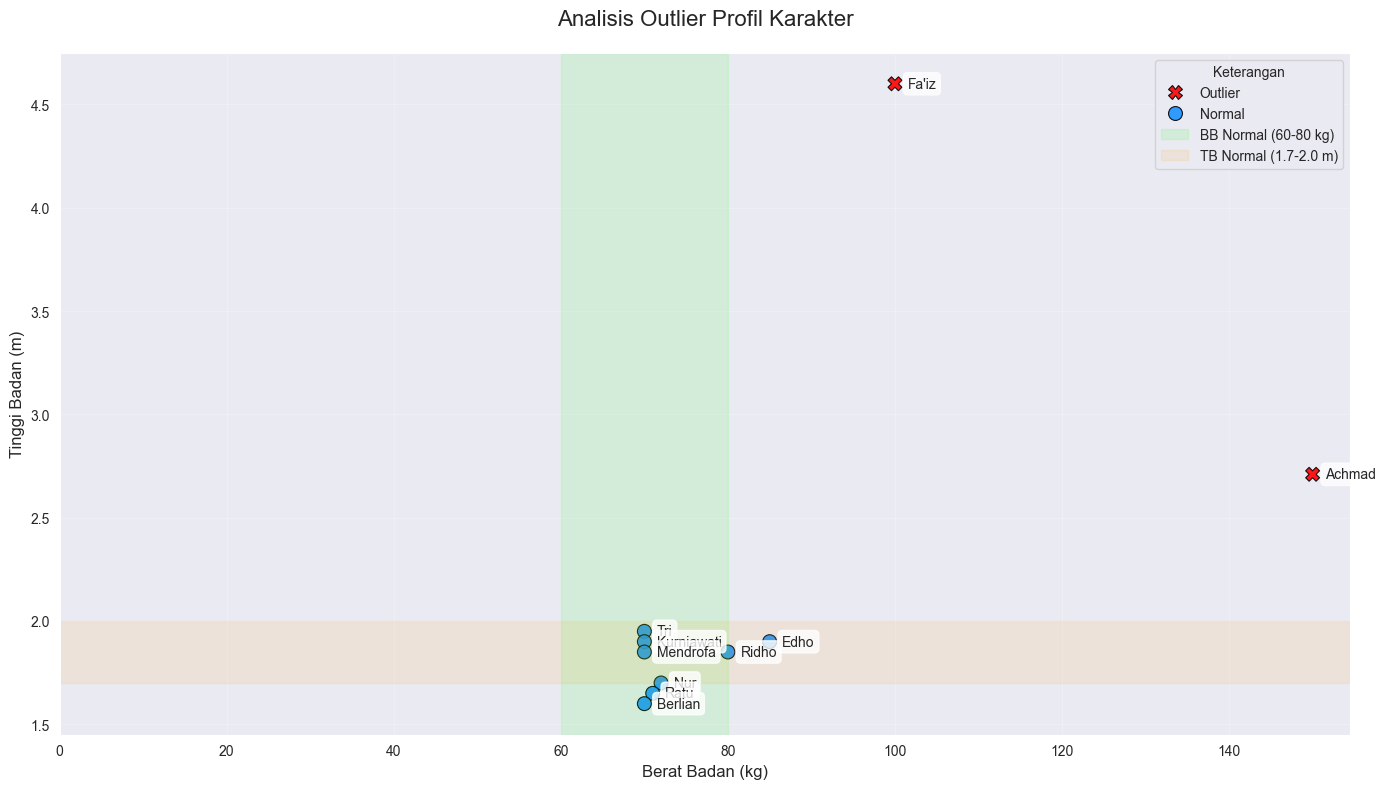

In [24]:
plt.figure(figsize=(14, 8))
sns.set_style("darkgrid")

scatter = sns.scatterplot(
    data=df,
    x="BB",
    y="TB",
    hue="Status",
    style="Status",
    palette={"Normal": "dodgerblue", "Outlier": "red"},
    markers={"Normal": "o", "Outlier": "X"},
    s=100,
    edgecolor="black",
    alpha=0.9
)

for _, row in df.iterrows():
    scatter.text(
        row["BB"] + 1.5,
        row["TB"],
        row["Nama"],
        ha='left',
        va='center',
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.8, boxstyle="round,pad=0.3")
    )

plt.axvspan(60, 80, color='lime', alpha=0.1, label='BB Normal (60-80 kg)')
plt.axhspan(1.7, 2.0, color='orange', alpha=0.1, label='TB Normal (1.7-2.0 m)')

plt.title("Analisis Outlier Profil Karakter", fontsize=16, pad=20)
plt.xlabel("Berat Badan (kg)", fontsize=12)
plt.ylabel("Tinggi Badan (m)", fontsize=12)
plt.legend(title="Keterangan", loc='upper right')
plt.xticks(np.arange(0, 160, 20))
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig("data/tugas3/assets/LOF-Cleaned", dpi=300)
plt.show()

df.to_json('data/tugas3/result.json', orient='records', indent=2, force_ascii=False)